# Task 4 Visualization 1

Node Link graph of artists and countries, to show links between them based on their popularity.

In [2]:
import networkx as nx
import nx_altair as nxa
import altair as alt
import pandas as pd
from networkx.drawing.nx_agraph import graphviz_layout
import plotly.plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from IPython.display import display

#note: for graphviz, need to install it separately, and also install the pygraphviz package.
#also, for plotly need to sign up and set the api key. refer to plotly set up guide on their website

alt.renderers.enable('notebook')
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

In [3]:
rankings_file_path = "../../data/Daily_Ranking.csv"

In [4]:
df = pd.read_csv(rankings_file_path)

First, need to calculate the top artists in different countries.
Then, need to set the connect them together in the graph.
The width of the link represents the strength of the popularity, could encode maybe the proportional no. of streams that the artist gets?

In [5]:
print(df['Region'].unique().tolist())
df.columns

['ec', 'fr', 'ar', 'fi', 'no', 'it', 'lt', 'ph', 'tw', 'nz', 'ee', 'tr', 'us', 'sv', 'cr', 'de', 'cl', 'jp', 'br', 'hn', 'gt', 'ch', 'hu', 'ca', 'pe', 'be', 'my', 'dk', 'bo', 'pl', 'at', 'pt', 'se', 'mx', 'pa', 'uy', 'is', 'es', 'cz', 'ie', 'nl', 'sk', 'co', 'sg', 'id', 'do', 'lu', 'gb', 'py', 'au', 'lv', 'gr', 'hk']


Index(['Position', 'Track Name', 'Artist', 'Streams', 'URL', 'Date', 'Region'], dtype='object')

In [98]:
regions = ['us', 'hk', 'gb', 'ch', 'jp', 'sg', 'au', 'nz', 'tw', 'br']  #only these 3 regions for now
country_grouped = df.loc[df['Region'].isin(regions)]
country_grouped = country_grouped[country_grouped['Position'] <= 1]   #first extract the top ten songs
country_grouped = country_grouped.drop(columns=['Track Name', 'Streams', 'URL', 'Date'])
country_grouped = country_grouped.groupby(['Region', 'Artist']).count() #Basically calculates the number of days that that artists songs have combined stayed on the top 10 rankings in that country
print(country_grouped.shape)
country_grouped = country_grouped.add_suffix('_count').reset_index()
country_grouped = country_grouped[country_grouped["Position_count"] > 7]
print("Unique Artists: {}".format(country_grouped['Artist'].nunique()))
print("Unique regions: {}".format(country_grouped['Region'].nunique()))

(274, 1)
Unique Artists: 78
Unique regions: 10


,Region,Artist,Position_count
0,au,5 Seconds of Summer,41
1,au,Ariana Grande,89
2,au,Childish Gambino,9
3,au,DJ Khaled,22
4,au,Dean Lewis,29


To join with the country names dataset

In [99]:
df_countries = pd.read_json("countries.json")
df_countries = df_countries.transpose()
df_countries = df_countries.drop(columns=['continent', 'capital', 'languages', 'native', 'phone', 'currency'])
df_countries = df_countries.rename(columns={'name':'Country'})
df_countries.head()
country_grouped['Region'] = country_grouped['Region'].str.upper()
country_grouped = country_grouped.merge(df_countries, how='inner', left_on='Region', right_index=True)

,Region,Artist,Position_count,Country
0,AU,5 Seconds of Summer,41,Australia
1,AU,Ariana Grande,89,Australia
2,AU,Childish Gambino,9,Australia
3,AU,DJ Khaled,22,Australia
4,AU,Dean Lewis,29,Australia


Try 1: Using nx_altair to draw the graph created using networkx. Really too simplistic.

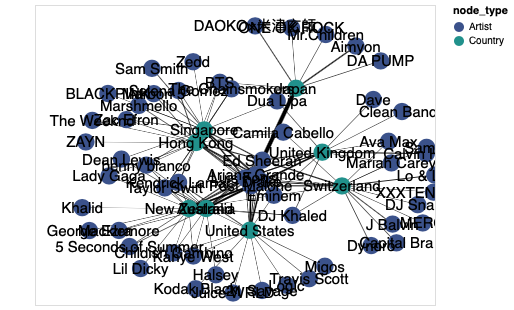

In [55]:
# using the nx_altair library
# not very powerful, seems that you cannot add labels to the nodes 
# https://stackoverflow.com/questions/21978487/improving-python-networkx-graph-layout - ideas for making the node placement better

G = nx.Graph()
unique_artists = country_grouped['Artist'].unique()
unique_countries = country_grouped['Country'].unique()

for i in unique_artists:
    G.add_node(i, name=i, node_type='Artist')
    
for i in unique_countries:
    G.add_node(i, name=i, node_type='Country')

for i, row in country_grouped.iterrows():
    G.add_edge(row['Artist'], row['Country'], weight=row['Position_count'], artist=row['Artist'], country=row['Country'])

# Compute positions for viz.
# pos = nx.spring_layout(G)      #pretty simple
# pos = nx.shell_layout(G, nlist=[unique_countries, unique_artists])    #pretty simple
# pos = graphviz_layout(G, prog='twopi')  #pretty good
pos = graphviz_layout(G, prog='neato')    #pretty interesting 

# Draw the graph using Altair using nx_altair
viz = nxa.draw_networkx(G, pos=pos, width='weight', node_color='node_type', node_label='name', cmap='viridis', node_tooltip=['name', 'node_type'], edge_tooltip=['artist', 'country', 'weight'])

# Show it as an interactive plot!
viz.interactive()

In [ ]:
G = nx.Graph()
unique_artists = country_grouped['Artist'].unique()
unique_countries = country_grouped['Country'].unique()

for i in unique_artists:
    G.add_node(i, name=i, node_type='Artist')
    
for i in unique_countries:
    G.add_node(i, name=i, node_type='Country')

for i, row in country_grouped.iterrows():
    G.add_edge(row['Artist'], row['Country'], weight=row['Position_count'], artist=row['Artist'], country=row['Country'])

# Compute positions for viz.
# pos = nx.spring_layout(G)      #pretty simple
# pos = nx.shell_layout(G, nlist=[unique_countries, unique_artists])    #pretty simple
# pos = graphviz_layout(G, prog='twopi')  #pretty good
pos = graphviz_layout(G, prog='neato')    #pretty interesting 
G.nodes(data=True)

Try 2: Using plotly to draw the graph used by networkx.

In [102]:
#first make the graph using networkx and calculate the positions to put the nodes in
G = nx.Graph()
unique_artists = country_grouped['Artist'].unique().tolist()
unique_countries = country_grouped['Country'].unique().tolist()

for i in unique_artists:
    G.add_node(i, name=i, node_type='Artist')
    
for i in unique_countries:
    G.add_node(i, name=i, node_type='Country')

for i, row in country_grouped.iterrows():
    G.add_edge(row['Artist'], row['Country'], weight=row['Position_count'], artist=row['Artist'], country=row['Country'])

# Compute positions for viz.
# pos = nx.spring_layout(G)      #pretty simple
# pos = nx.shell_layout(G, nlist=[unique_countries, unique_artists])    #pretty simple
# pos = graphviz_layout(G, prog='twopi')  #pretty good
pos = graphviz_layout(G, prog='neato')    #pretty interesting 

#then use plotly to actually plot and show the graph

traces = []

edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines',
    name='Artist-Country Connection',
    showlegend=False)

for edge in G.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace = go.Scatter(
        x=[x0, x1, None],
        y=[y0, y1, None],
        line=dict(width=edge[2]['weight']*0.01,color='#888'),
        hoverinfo='none',
        mode='lines',
        name='Artist-Country Connection',
        showlegend=False)
    traces.append(edge_trace)


artist_nodes = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=False,
        colorscale='YlGnBu',
        color=1,
        size=10,
        line=dict(width=2),
        symbol='circle'),
    name='Artist')

country_nodes = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers+text',
    hoverinfo='text',
    marker=dict(
        showscale=False,
        colorscale='YlGnBu',
        color=0,
        size=20,
        line=dict(width=2),
        symbol='square'),
    name='Country')

for node in G.nodes():
    x, y = pos[node]
    if node in unique_artists:
        artist_nodes['x'] += tuple([x])
        artist_nodes['y'] += tuple([y])
        artist_nodes['text'] += tuple([node])
    else:
        country_nodes['x'] += tuple([x])
        country_nodes['y'] += tuple([y])
        country_nodes['text'] += tuple([node])
        
traces.append(artist_nodes)
traces.append(country_nodes)

fig = go.Figure(data=traces,
             layout=go.Layout(
                title='Relationship between Artists and Countries',
                titlefont=dict(size=16),
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

py.iplot(fig, filename='networkx')

Try 3: using ipython widgets to make changing which data to show easy

To use, set the value that you want and then run the 3rd cell

In [6]:
#first create dictionary of region code to country name for simplicity later
all_region_codes = ['ec', 'fr', 'ar', 'fi', 'no', 'it', 'lt', 'ph', 'tw', 'nz', 'ee', 'tr', 'us', 'sv', 'cr', 'de', 'cl', 'jp', 'br', 'hn', 'gt', 'ch', 'hu', 'ca', 'pe', 'be', 'my', 'dk', 'bo', 'pl', 'at', 'pt', 'se', 'mx', 'pa', 'uy', 'is', 'es', 'cz', 'ie', 'nl', 'sk', 'co', 'sg', 'id', 'do', 'lu', 'gb', 'py', 'au', 'lv', 'gr', 'hk']
df_countries = pd.read_json("countries.json")
df_countries = df_countries.transpose()
country_names = {r:df_countries.loc[r.upper()]['name'] for r in all_region_codes}

In [7]:
print("Till Position")
tp = widgets.IntSlider(min=1, max=200)
display(tp)
print("Min Days in Top Positions")
min_tp = widgets.IntSlider(min=1, max=100)
display(min_tp)
print("Select Regions to show in the Graph")
checkboxes = []
for i in all_region_codes:
    c = widgets.Checkbox(description=country_names[i])
    if i == 'us':
        c.value=True
    checkboxes.append(c)
last = 0
for i in range(1, len(checkboxes)):
    if i%5 == 0 or i == len(checkboxes) - 1:
        display(widgets.HBox(checkboxes[last:i]))
        last = i

Till Position


IntSlider(value=1, max=200, min=1)

Min Days in Top Positions


IntSlider(value=1, min=1)

Select Regions to show in the Graph


HBox(children=(Checkbox(value=False, description='Ecuador'), Checkbox(value=False, description='France'), Checkbox(value=False, description='Argentina'), Checkbox(value=False, description='Finland'), Checkbox(value=False, description='Norway')))

HBox(children=(Checkbox(value=False, description='Italy'), Checkbox(value=False, description='Lithuania'), Checkbox(value=False, description='Philippines'), Checkbox(value=False, description='Taiwan'), Checkbox(value=False, description='New Zealand')))

HBox(children=(Checkbox(value=False, description='Estonia'), Checkbox(value=False, description='Turkey'), Checkbox(value=True, description='United States'), Checkbox(value=False, description='El Salvador'), Checkbox(value=False, description='Costa Rica')))

HBox(children=(Checkbox(value=False, description='Germany'), Checkbox(value=False, description='Chile'), Checkbox(value=False, description='Japan'), Checkbox(value=False, description='Brazil'), Checkbox(value=False, description='Honduras')))

HBox(children=(Checkbox(value=False, description='Guatemala'), Checkbox(value=False, description='Switzerland'), Checkbox(value=False, description='Hungary'), Checkbox(value=False, description='Canada'), Checkbox(value=False, description='Peru')))

HBox(children=(Checkbox(value=False, description='Belgium'), Checkbox(value=False, description='Malaysia'), Checkbox(value=False, description='Denmark'), Checkbox(value=False, description='Bolivia'), Checkbox(value=False, description='Poland')))

HBox(children=(Checkbox(value=False, description='Austria'), Checkbox(value=False, description='Portugal'), Checkbox(value=False, description='Sweden'), Checkbox(value=False, description='Mexico'), Checkbox(value=False, description='Panama')))

HBox(children=(Checkbox(value=False, description='Uruguay'), Checkbox(value=False, description='Iceland'), Checkbox(value=False, description='Spain'), Checkbox(value=False, description='Czech Republic'), Checkbox(value=False, description='Ireland')))

HBox(children=(Checkbox(value=False, description='Netherlands'), Checkbox(value=False, description='Slovakia'), Checkbox(value=False, description='Colombia'), Checkbox(value=False, description='Singapore'), Checkbox(value=False, description='Indonesia')))

HBox(children=(Checkbox(value=False, description='Dominican Republic'), Checkbox(value=False, description='Luxembourg'), Checkbox(value=False, description='United Kingdom'), Checkbox(value=False, description='Paraguay'), Checkbox(value=False, description='Australia')))

HBox(children=(Checkbox(value=False, description='Latvia'), Checkbox(value=False, description='Greece')))

In [9]:
#run this cell to draw you're desired graph!

def make_networkx_graph(regions, till_position, min_days_in_position):
    country_grouped = df.loc[df['Region'].isin(regions)]
    country_grouped = country_grouped[country_grouped['Position'] <= till_position]   #first extract the top ten songs
    country_grouped = country_grouped.drop(columns=['Track Name', 'Streams', 'URL', 'Date'])
    country_grouped = country_grouped.groupby(['Region', 'Artist']).count() #Basically calculates the number of days that that artists songs have combined stayed on the top 10 rankings in that country
    print(country_grouped.shape)
    country_grouped = country_grouped.add_suffix('_count').reset_index()
    country_grouped = country_grouped[country_grouped["Position_count"] >= min_days_in_position]
    print("Unique Artists: {}".format(country_grouped['Artist'].nunique()))
    print("Unique regions: {}".format(country_grouped['Region'].nunique()))
    
    df_countries = pd.read_json("countries.json")
    df_countries = df_countries.transpose()
    df_countries = df_countries.drop(columns=['continent', 'capital', 'languages', 'native', 'phone', 'currency'])
    df_countries = df_countries.rename(columns={'name':'Country'})
    df_countries.head()
    country_grouped['Region'] = country_grouped['Region'].str.upper()
    country_grouped = country_grouped.merge(df_countries, how='inner', left_on='Region', right_index=True)
    
    G = nx.Graph()
    unique_artists = country_grouped['Artist'].unique().tolist()
    unique_countries = country_grouped['Country'].unique().tolist()

    for i in unique_artists:
        G.add_node(i, name=i, node_type='Artist')

    for i in unique_countries:
        G.add_node(i, name=i, node_type='Country')

    for i, row in country_grouped.iterrows():
        G.add_edge(row['Artist'], row['Country'], weight=row['Position_count'], artist=row['Artist'], country=row['Country'])
        
    return G, unique_artists, unique_countries

def draw_plotly_graph(regions, till_position, min_days_in_position):
    G, unique_artists, unique_countries = make_networkx_graph(regions, till_position, min_days_in_position)
    
    pos = graphviz_layout(G, prog='neato')    #pretty interesting 

    traces = []

    edge_trace = go.Scatter(
        x=[],
        y=[],
        line=dict(width=0.5,color='#888'),
        hoverinfo='none',
        mode='lines',
        name='Artist-Country Connection',
        showlegend=False)

    for edge in G.edges(data=True):
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_trace = go.Scatter(
            x=[x0, x1, None],
            y=[y0, y1, None],
            line=dict(width=edge[2]['weight']*0.01,color='#888'),
            hoverinfo='none',
            mode='lines',
            name='Artist-Country Connection',
            showlegend=False)
        traces.append(edge_trace)


    artist_nodes = go.Scatter(
        x=[],
        y=[],
        text=[],
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=False,
            colorscale='YlGnBu',
            color=1,
            size=10,
            line=dict(width=2),
            symbol='circle'),
        name='Artist')

    country_nodes = go.Scatter(
        x=[],
        y=[],
        text=[],
        mode='markers+text',
        hoverinfo='text',
        marker=dict(
            showscale=False,
            colorscale='YlGnBu',
            color=0,
            size=20,
            line=dict(width=2),
            symbol='square-dot'),
        name='Country',
        textposition='top center')

    for node in G.nodes():
        x, y = pos[node]
        if node in unique_artists:
            artist_nodes['x'] += tuple([x])
            artist_nodes['y'] += tuple([y])
            artist_nodes['text'] += tuple([node])
        else:
            country_nodes['x'] += tuple([x])
            country_nodes['y'] += tuple([y])
            country_nodes['text'] += tuple([node])

    traces.append(artist_nodes)
    traces.append(country_nodes)

    fig = go.Figure(data=traces,
                 layout=go.Layout(
                    title='Relationship between Artists and Countries',
                    titlefont=dict(size=16),
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

    return py.iplot(fig, filename='networkx')

#code to read the values from the user inputs in the previous cell and then plot the graph accordingly

regions_to_use = [r for i,r in enumerate(all_region_codes) if checkboxes[i].value]
till_pos = tp.value
till_pos_days = min_tp.value
draw_plotly_graph(regions=regions_to_use, till_position=till_pos, min_days_in_position=till_pos_days)
# draw_plotly_graph(regions=['us', 'hk', 'gb', 'ch', 'jp', 'sg', 'au', 'nz', 'tw', 'br'], till_position=1, min_days_in_position=10)

(231, 1)
Unique Artists: 146
Unique regions: 8
